In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

from contextual_bandit import ContextBanditSim


In [2]:
def moving_average(a, n=5):
    """Calculate moving average with window of `n`."""
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n



In [3]:
class QAgent:
    """A basic agent estimating Q-values to weight non-contextual
    multi-armed bandits.

    Parameters:
    num_bandits: Specifies the number of bandits in the current problem.
    eps: Using epsilon-greedy method, this determines the probability of
         the agent choosing an action at random.
    """
    def __init__(self, num_bandits, eps=0.1):
        self.num_bandits = num_bandits
        self.eps = eps

        self.n = np.zeros(num_bandits, dtype=np.int)  # action counts
        self.Q = np.zeros(num_bandits, dtype=np.float)  # Q-values for each action

        self.actions = []
        self.rewards = []

    def choose_action(self, iter_num, _ctx):
        if np.random.rand() < self.eps:
            action = int(np.random.randint(self.num_bandits))
        else:
            action = int(np.argmax(self.Q))
        self.n[action] += 1

        if iter_num == 0:
            totals = np.zeros(self.num_bandits)
            totals[action] = 1
            self.actions.append(totals)
        else:
            totals = self.actions[iter_num-1].copy()
            totals[action] += 1
            self.actions.append(totals)

        return action

    def update_rewards(self, iter_num, _ctx, action, reward):
        self.Q[action] += (1.0/self.n[action]) * (reward - self.Q[action])
        self.rewards.append(reward)


In [4]:
def multi_bandit_gen_context():
    """Dummy function, returns empty context."""
    return np.array([], dtype=np.float)

def make_multi_bandit_reward(probs):
    """Creates a multi-armed bandit reward function with the specified
    probabilities.
    """
    def multi_bandit_reward(_ctx, _num_bandits, action):
        """Randomly selects a reward for the given action, based on the
        specified probability for that action.
        """
        regret = np.max(probs) - probs[action]
        if np.random.rand() < probs[action]:
            return (1, regret)
        else:
            return (0, regret)
    return multi_bandit_reward


In [5]:
# basic multi-armed (non-contextual) bandit problem. Four bandits with 
# differing probabilities of receiving reward (either 0 or 1).
num_bandits = 4
multi_bandit_reward = make_multi_bandit_reward([0.2, 0, 0.5, 0.7])

q_agent = QAgent(num_bandits, eps=0.01)
q_multi_sim = ContextBanditSim(multi_bandit_gen_context,
    multi_bandit_reward, num_bandits, q_agent)

results_q = q_multi_sim.run_sim(5000)

print("Mean: {:.2f}, SD: {:.2f}".format(
    np.mean(results_q["rewards"]), np.std(results_q["rewards"])))
print("Min: {:.2f}, Max: {:.2f}".format(
    np.min(results_q["rewards"]), np.max(results_q["rewards"])))


Iteration: 1000
Iteration: 2000
Iteration: 3000
Iteration: 4000
Iteration: 5000
Mean: 0.65, SD: 0.48
Min: 0.00, Max: 1.00


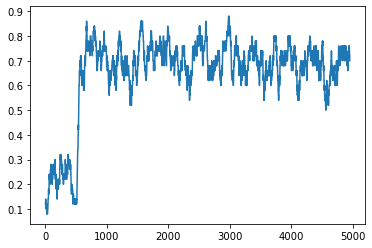

[0.21328671 0.         0.53846154 0.70472084]


In [6]:
q_rew_mv_avg = moving_average(q_agent.rewards, n=50)
plt.plot(range(len(q_rew_mv_avg)), q_rew_mv_avg)
plt.show()

print(q_agent.Q)


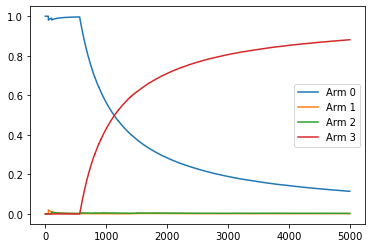

In [7]:
bandit_props = np.zeros((5000, num_bandits))
for i, totals in enumerate(q_agent.actions):
    bandit_props[i] = totals / np.sum(totals)

for b in range(num_bandits):
    plt.plot(range(5000), bandit_props[:, b], label=f"Arm {b}")
plt.legend()
plt.show()


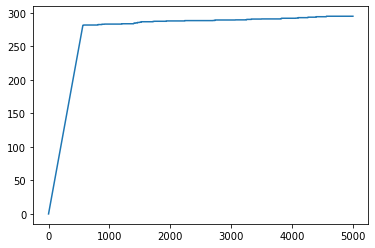

In [8]:
q_regret = [q_multi_sim.regret(T) for T in range(5000)]
plt.plot(range(5000), q_regret)
plt.show()




In [9]:
class RandomAgent:
    """Chooses an action at random."""
    def __init__(self, num_bandits):
        self.num_bandits = num_bandits
    
    def choose_action(self, _iter_num, _ctx):
        return np.random.choice(self.num_bandits)
    
    def update_rewards(self, _iter_num, _ctx, _action, _reward):
        pass


In [10]:
class QContextAgent:
    """A basic agent estimating Q-values to weight (discrete) contextual
    multi-armed bandits.

    Instead of a single estimate of Q-values for each bandit, this stores
    an estimate of Q-values for each bandit in a given context. Thus,
    contexts must be discrete groups (e.g., age groups rather than age).

    Parameters:
    num_bandits: Specifies the number of bandits in the current problem.
    age_bins: Numpy array of age groups to split age into. (See
              numpy.digitize() for format.)
    eps: Using epsilon-greedy method, this determines the probability of
         the agent choosing an action at random.
    """
    def __init__(self, num_bandits, age_bins, eps=0.1):
        self.num_bandits = num_bandits
        self.age_bins = age_bins
        self.eps = eps

        self.records = {}

        self.actions = []  # overall actions, regardless of context
        self.rewards = []

    def _parse_ctx(self, ctx):
        age_bin = np.digitize(ctx[1], self.age_bins)
        return (ctx[0], age_bin)

    def choose_action(self, iter_num, ctx):
        ctx = self._parse_ctx(ctx)
        if ctx not in self.records.keys():
            self.records[ctx] = {
                "n": np.zeros(self.num_bandits, dtype=np.int),  # action counts
                "Q": np.ones(self.num_bandits, dtype=np.float)  # Q-values for each action
            }

        if np.random.rand() < self.eps:
            action = int(np.random.randint(self.num_bandits))
        else:
            action = int(np.argmax(self.records[ctx]))
        self.records[ctx]["n"][action] += 1

        if iter_num == 0:
            totals = np.zeros(self.num_bandits)
            totals[action] = 1
            self.actions.append(totals)
        else:
            totals = self.actions[iter_num-1].copy()
            totals[action] += 1
            self.actions.append(totals)

        return action

    def update_rewards(self, iter_num, ctx, action, reward):
        ctx = self._parse_ctx(ctx)
        self.records[ctx]["Q"][action] += (1.0/self.records[ctx]["n"][action]) * (reward - self.records[ctx]["Q"][action])
        self.rewards.append(reward)


In [11]:
def context_bandit_gen_context():
    """Randomly selects a gender (0 or 1) and age (between 18 and 65)
    from a uniform distribution.
    """
    gender = np.random.choice([0, 1])
    age = np.random.choice(range(18, 65))
    return np.array([gender, age])

def context_bandit_prob(ctx, action):
    """Given a context (gender, age) and an action (0 or 1), provides the
    probability of receiving a reward. Probability is determined based on
    a logistic function with pre-specified parameters.
    """
    gender = ctx[0]
    age = ctx[1]
    norm_age = (age - 18) / (65 - 18)
    alpha = (-0.3) + (-0.6)*action + (-0.4)*gender + 0.8*gender*action + 0.7*norm_age + 0.5*norm_age*action
    prob = 1 / (1 + np.exp(-alpha))
    return prob

def context_bandit_reward(ctx, num_bandits, action):
    """Given a context (gender, age) and an action (0 or 1), provides a
    reward based on a pre-specified probability distribution.
    """
    all_probs = [context_bandit_prob(ctx, a) for a in range(num_bandits)]
    regret = np.max(all_probs) - all_probs[action]
    if np.random.rand() < all_probs[action]:
        return (1, regret)
    else:
        return (0, regret)


In [12]:
# contextual bandit problem. Two bandits with probabilities differing by
# gender and age.
num_bandits = 2

rand_agent = RandomAgent(num_bandits)
rand_sim = ContextBanditSim(context_bandit_gen_context,
    context_bandit_reward, num_bandits, rand_agent)

results_rand = rand_sim.run_sim(10000)

print("Mean: {:.2f}, SD: {:.2f}".format(
    np.mean(results_rand["rewards"]), np.std(results_rand["rewards"])))
print("Min: {:.2f}, Max: {:.2f}".format(
    np.min(results_rand["rewards"]), np.max(results_rand["rewards"])))


Iteration: 1000
Iteration: 2000
Iteration: 3000
Iteration: 4000
Iteration: 5000
Iteration: 6000
Iteration: 7000
Iteration: 8000
Iteration: 9000
Iteration: 10000
Mean: 0.46, SD: 0.50
Min: 0.00, Max: 1.00


In [13]:
q_context_agent = QContextAgent(num_bandits,
    age_bins=np.array([18, 26, 36, 46, 56, 66]), eps=0.05)
q_context_sim = ContextBanditSim(context_bandit_gen_context,
    context_bandit_reward, num_bandits, q_context_agent)

results_qc = q_context_sim.run_sim(50000)

print("Mean: {:.2f}, SD: {:.2f}".format(
    np.mean(results_qc["rewards"]), np.std(results_qc["rewards"])))
print("Min: {:.2f}, Max: {:.2f}".format(
    np.min(results_qc["rewards"]), np.max(results_qc["rewards"])))


Iteration: 1000
Iteration: 2000
Iteration: 3000
Iteration: 4000
Iteration: 5000
Iteration: 6000
Iteration: 7000
Iteration: 8000
Iteration: 9000
Iteration: 10000
Iteration: 11000
Iteration: 12000
Iteration: 13000
Iteration: 14000
Iteration: 15000
Iteration: 16000
Iteration: 17000
Iteration: 18000
Iteration: 19000
Iteration: 20000
Iteration: 21000
Iteration: 22000
Iteration: 23000
Iteration: 24000
Iteration: 25000
Iteration: 26000
Iteration: 27000
Iteration: 28000
Iteration: 29000
Iteration: 30000
Iteration: 31000
Iteration: 32000
Iteration: 33000
Iteration: 34000
Iteration: 35000
Iteration: 36000
Iteration: 37000
Iteration: 38000
Iteration: 39000
Iteration: 40000
Iteration: 41000
Iteration: 42000
Iteration: 43000
Iteration: 44000
Iteration: 45000
Iteration: 46000
Iteration: 47000
Iteration: 48000
Iteration: 49000
Iteration: 50000
Mean: 0.46, SD: 0.50
Min: 0.00, Max: 1.00


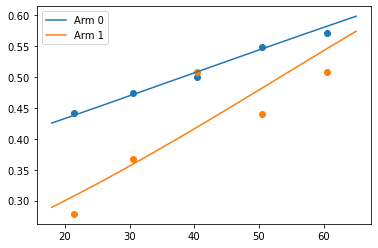

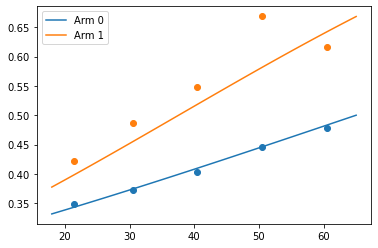

In [14]:
probs_men = [
    [context_bandit_prob(np.array([0, age]), 0) for age in range(18, 66)],
    [context_bandit_prob(np.array([0, age]), 1) for age in range(18, 66)]]
probs_women = [
    [context_bandit_prob(np.array([1, age]), 0) for age in range(18, 66)],
    [context_bandit_prob(np.array([1, age]), 1) for age in range(18, 66)]]

for b in range(num_bandits):
    plt.plot(range(18, 66), probs_men[b], label=f"Arm {b}")
    vals = [q_context_agent.records[(0, x)]["Q"][b] for x in range(1, 6)]
    plt.scatter([21.5, 30.5, 40.5, 50.5, 60.5], vals)
plt.legend()
plt.show()

for b in range(num_bandits):
    plt.plot(range(18, 66), probs_women[b], label=f"Arm {b}")
    vals = [q_context_agent.records[(1, x)]["Q"][b] for x in range(1, 6)]
    plt.scatter([21.5, 30.5, 40.5, 50.5, 60.5], vals)
plt.legend()
plt.show()


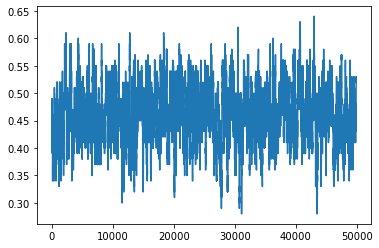

In [15]:
qc_rew_mv_avg = moving_average(q_context_agent.rewards, n=100)
plt.plot(range(len(qc_rew_mv_avg)), qc_rew_mv_avg)
plt.show()


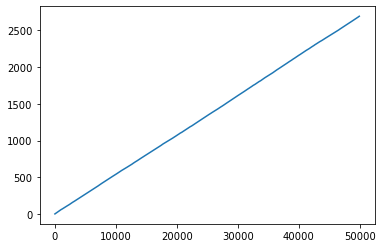

Final total regret: 2692.8345259696225


In [16]:
qc_regret = [q_context_sim.regret(T) for T in range(0, 50000, 100)]
plt.plot(range(0, 50000, 100), qc_regret)
plt.show()
print(f"Final total regret: {qc_regret[-1]}")



In [17]:
class LinUCBAgent:
    """An agent using the Linear UCB algorithm to weight contextual
    multi-armed bandits.

    This variant of the UCB algorithm for contextual bandits estimates a
    disjoint (i.e., not shared between arms) linear model with ridge
    regression: https://arxiv.org/abs/1003.0146

    Parameters:
    num_bandits: Specifies the number of bandits in the current problem.
    num_dim: Number of dimensions for the context.
    alpha: Tuning parameter on the variance of the estimates.
    """
    def __init__(self, num_bandits, num_dim, alpha):
        self.num_bandits = num_bandits
        self.num_dim = num_dim
        self.alpha = alpha

        self.A = np.array([np.eye(self.num_dim) for _ in range(self.num_bandits)])  # a x dim x dim
        self.b = np.array([np.zeros((self.num_dim, 1)) for _ in range(self.num_bandits)])  # a x dim

        self.actions = []  # overall actions, regardless of context
        self.rewards = []

    def _parse_ctx(self, ctx):
        norm_age = (ctx[1] - 18) / (65 - 18)
        return np.array((ctx[0], norm_age))

    def choose_action(self, iter_num, ctx):
        ctx = self._parse_ctx(ctx)
        p = np.zeros(self.num_bandits)
        for a in range(self.num_bandits):
            Ainv = np.linalg.inv(self.A[a])  # dim x dim
            theta = np.dot(Ainv, self.b[a])  # dim x 1
            p[a] = (np.dot(theta.T, self.b[a]) +
                self.alpha * np.sqrt(np.dot(np.dot(ctx.T, Ainv), ctx)))
                # 1 x 1

        # selects max, except where options are close to being tied, in
        # which case, it selects one of the max values at random
        action = int(np.random.choice(np.flatnonzero(np.isclose(p, p.max()))))
        # action = int(np.argmax(p))

        if iter_num == 0:
            totals = np.zeros(self.num_bandits)
            totals[action] = 1
            self.actions.append(totals)
        else:
            totals = self.actions[iter_num-1].copy()
            totals[action] += 1
            self.actions.append(totals)

        return action

    def update_rewards(self, iter_num, ctx, action, reward):
        ctx = self._parse_ctx(ctx)
        self.A[action] = self.A[action] + np.dot(ctx, ctx.T)  # dim x dim
        self.b[action] = self.b[action] + reward * ctx[:, np.newaxis]  # dim x 1
        self.rewards.append(reward)


In [18]:
linucb_agent = LinUCBAgent(num_bandits, num_dim=2, alpha=0.1)
linucb_sim = ContextBanditSim(context_bandit_gen_context,
    context_bandit_reward, num_bandits, linucb_agent)

results_ucb = linucb_sim.run_sim(50000)

print("Mean: {:.2f}, SD: {:.2f}".format(
    np.mean(results_ucb["rewards"]), np.std(results_ucb["rewards"])))
print("Min: {:.2f}, Max: {:.2f}".format(
    np.min(results_ucb["rewards"]), np.max(results_ucb["rewards"])))


Iteration: 1000
Iteration: 2000
Iteration: 3000
Iteration: 4000
Iteration: 5000
Iteration: 6000
Iteration: 7000
Iteration: 8000
Iteration: 9000
Iteration: 10000
Iteration: 11000
Iteration: 12000
Iteration: 13000
Iteration: 14000
Iteration: 15000
Iteration: 16000
Iteration: 17000
Iteration: 18000
Iteration: 19000
Iteration: 20000
Iteration: 21000
Iteration: 22000
Iteration: 23000
Iteration: 24000
Iteration: 25000
Iteration: 26000
Iteration: 27000
Iteration: 28000
Iteration: 29000
Iteration: 30000
Iteration: 31000
Iteration: 32000
Iteration: 33000
Iteration: 34000
Iteration: 35000
Iteration: 36000
Iteration: 37000
Iteration: 38000
Iteration: 39000
Iteration: 40000
Iteration: 41000
Iteration: 42000
Iteration: 43000
Iteration: 44000
Iteration: 45000
Iteration: 46000
Iteration: 47000
Iteration: 48000
Iteration: 49000
Iteration: 50000
Mean: 0.47, SD: 0.50
Min: 0.00, Max: 1.00


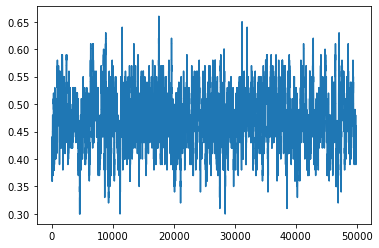

In [19]:
linucb_rew_mv_avg = moving_average(linucb_agent.rewards, n=100)
plt.plot(range(len(linucb_rew_mv_avg)), linucb_rew_mv_avg)
plt.show()


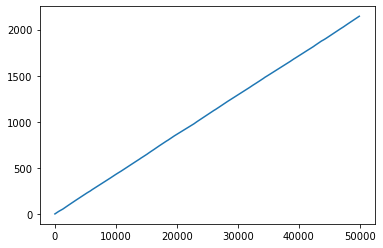

Final total regret: 2144.897098825685


In [20]:
linucb_regret = [linucb_sim.regret(T) for T in range(0, 50000, 100)]
plt.plot(range(0, 50000, 100), linucb_regret)
plt.show()
print(f"Final total regret: {linucb_regret[-1]}")


In [21]:
# grid search over alpha
linucb_tests = {
    "alpha": [],
    "regret": []
}

for alpha in range(0, 30, 2):
    l_agent = LinUCBAgent(num_bandits, num_dim=2, alpha=alpha/10.0)
    l_sim = ContextBanditSim(context_bandit_gen_context,
        context_bandit_reward, num_bandits, l_agent)
    l_results = l_sim.run_sim(50000, verbose=False)
    linucb_tests["alpha"].append(alpha/10.0)
    linucb_tests["regret"].append(l_sim.regret(50000))


[2718.6667682578786, 2137.455020271843, 2702.8061473823727, 2724.121251844349, 2159.3450203450775, 2714.0496935578876, 2705.9496940559175, 2703.1609951558253, 2146.9382706503743, 2735.038851711859, 2177.0919631208812, 2155.4779045300643, 2151.212607046433, 2711.869885576258, 2153.1028517645655]


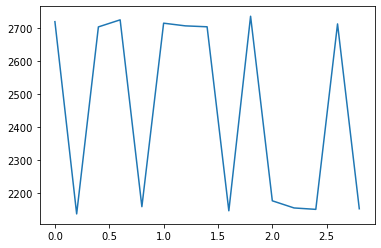

In [22]:
print(linucb_tests["regret"])
plt.plot(linucb_tests["alpha"], linucb_tests["regret"])
plt.show()